In [ ]:
cov = 1  # 1 means simple (0.03x), 2 means double (0.06x), etc.
slice='B'

base_dir = f'/Users/dd/work/svc/data/silver_{slice}_2_01'

clusters = open(f'{base_dir}/spectral_clustering').readlines()[0][:-1].split(',')
gt_lines = open(f'{base_dir}/../mapping{slice}.tsv').readlines()

# contains <cell_id, ground_truth, cluster>, where "ground truth" is the result of CNV analysis
result = open(f'{base_dir}/../cell_id_gt_spectral', 'w')

barcode_to_idx_lines = open(f'{base_dir}/../barcode_to_idx_{slice}.map').readlines()

print(
    f'{len(clusters)} clusters, {len(barcode_to_idx_lines)} barcode->id mappings, {len(gt_lines)} ground truth entries')

barcode_to_cell_idx = {}
cell_idx_to_barcode = {}
for line in barcode_to_idx_lines:
    barcode, cell_idx = line.split('\t')
    barcode = barcode.split('_')[-1]
    barcode = barcode.split('-')[0]
    cell_idx = int(cell_idx[:-1])
    barcode_to_cell_idx[barcode] = cell_idx
    cell_idx_to_barcode[cell_idx] = barcode

barcode_to_cell_group = {}
for gt_line in gt_lines:
    gt_line = gt_line.split('\t')
    cell_id_str = gt_line[0]
    cell_group = gt_line[2][:-1]
    barcode_to_cell_group[cell_id_str] = cell_group

group_count = 3

id_to_cluster_a = {}
id_to_cluster_b = {}
id_to_cluster_c = {}

other_clusters=0
for i in range(0, len(clusters)):
    cell_id_str = cell_idx_to_barcode[i]
    if cell_id_str not in barcode_to_cell_group:
        print(cell_id_str)
    cell_group = barcode_to_cell_group[cell_id_str]

    result.write(cell_id_str + '\t' + cell_group + '\t' + clusters[i] + '\n')

    if int(clusters[i]) == 0:
        if cell_group not in id_to_cluster_a:
            id_to_cluster_a[cell_group] = 1
        else:
            id_to_cluster_a[cell_group] += 1
    elif int(clusters[i]) == 1:
        if cell_group not in id_to_cluster_b:
            id_to_cluster_b[cell_group] = 1
        else:
            id_to_cluster_b[cell_group] += 1
    elif int(clusters[i]) == 2:
        if cell_group not in id_to_cluster_c:
            id_to_cluster_c[cell_group] = 1
        else:
            id_to_cluster_c[cell_group] += 1
    else:
        other_clusters+=1

print("Other clusters: ", other_clusters)

for id, count_a in id_to_cluster_a.items():
    count_b = 0
    count_c = 0
    if id in id_to_cluster_b:
        count_b = id_to_cluster_b[id]
        del id_to_cluster_b[id]
    if id in id_to_cluster_c:
        count_c = id_to_cluster_c[id]
        del id_to_cluster_c[id]
    if count_c > 0:
        print(f'{id}: {count_a}/{count_b}/{count_c}')
    else:
        print(f'{id}: {count_a}/{count_b}')

print('==============')

for id, count_b in id_to_cluster_b.items():
    print(f'{id}: 0/{count_b}')

print('==============')

for id, count_c in id_to_cluster_c.items():
    print(f'{id}: 0/{count_c}')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cov = 1  # 1 means simple (0.03x), 2 means double (0.06x), etc.
slice = 'B'
base_dir = f'/Users/dd/work/svc/data/silver_{slice}_5_05'


fploidy = open(f'{base_dir}/../ploidy_all').readlines()
ploidy_map = {}
for p in fploidy:
    cell_id, ploidy = p[:-1].split(',')
    cell_id = cell_id.split('-')[0]
    ploidy_map[cell_id] = float(ploidy)

eigenvectors = np.loadtxt(f'{base_dir}/sim_mat_eigenvectors_norm.csv')

#id_to_group = open(f'{base_dir}/../breast_group_{cov}').readlines()[0].split(',')

# different from clustering_info above: it only contains the cells that were actually processed, together
# with the gt clustering *and* our clustering
clustering_info = open(f'{base_dir}/../cell_id_gt_spectral').readlines()

print(f'Gt lines {len(clustering_info)}')

# for each type of cell (e.g. Clone159, Clone19), contains the (x,y) coordinates given by the 2nd and 3rd eigenvectors
# this allows us to visualize if the clusters are separable in 2D
cell_name_to_xy = {}

x = eigenvectors[:, 1]
y = eigenvectors[:, 2]
num_cells = x.shape[0]

x1 = []
y1 = []
x2 = []
y2 = []
p1 = []
p2 = []

print('Eigenvectors size: ', x.shape[0], '. Cells to process: ', len(clustering_info))

j = 0
for i in range(0, len(clustering_info)):
    gt_str = clustering_info[i].split('\t')
    cell_barcode = gt_str[0]
    cluster_name = gt_str[1]
    cluster = int(gt_str[2])

    if cluster == 16383:  # cell doesn't belong to current subcluster
        continue

    idx = i # int(id_to_group[i])

    if idx >= num_cells:  # shouldn't happen?
        j += 1
        continue

    
    if cluster_name not in cell_name_to_xy:
        cell_name_to_xy[cluster_name] = ([x[idx]], [y[idx]], [ploidy_map[cell_barcode]])
    else:
        cell_name_to_xy[cluster_name][0].append(x[idx])
        cell_name_to_xy[cluster_name][1].append(y[idx])
        cell_name_to_xy[cluster_name][2].append(ploidy_map[cell_barcode])

    if cluster == 0:
        x1.append(x[idx])
        y1.append(y[idx])
        p1.append(ploidy_map[cell_barcode])
    else:
        x2.append(x[idx])
        y2.append(y[idx])
        p2.append(ploidy_map[cell_barcode])

print('Skipped ', j, ' records.')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(x1, y1, label='tumor', color='red')
axs[0].scatter(x2, y2, label='healthy', color='blue')
axs[0].set(xlabel='2nd eigenvector', ylabel='3rd eigenvector')

# fig, axs = plt.subplots(1)

axs[1].scatter(x2, y2, label='healthy', color='blue')
axs[1].scatter(x1, y1, label='tumor', color='red')
axs[1].set(xlabel='2nd eigenvector', ylabel='3rd eigenvector')

fig, axs = plt.subplots(1)

for k, (v1, v2, v3) in cell_name_to_xy.items():
    if k=='None':
        axs.scatter(v1, v2, label=k, alpha=0.1)
    else:
        axs.scatter(v1, v2, label=k)

# This plots the "None" cells at the end
# (v1,v2) = cell_name_to_xy['None']
# axs.scatter(v1, v2, label='None')

axs.set(xlabel='2nd eigenvector', ylabel='3rd eigenvector')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
axs.legend()

In [ ]:
# Generate a mapping that groups multiple cells together based on the CNV "ground truth"

# how many cells of the same type to merge together
merge_count = 2

bam_list = open('/Users/dd/work/svc/data/bam_list').readlines()

bam_name_to_cell_id = {}
i = 0
for line in bam_list:
    bam_name_to_cell_id[line[13:-7]] = i
    i += 1
    
gt_lines = open('/Users/dd/work/svc/data/mappingB.tsv').readlines()

id_to_group = {}
id_to_count = {}
group_count = 0


for line in gt_lines:
    cols = line.split('\t')
    
    if cols[0] not in bam_name_to_cell_id:
        continue
        
    cell_id = bam_name_to_cell_id[cols[0]]
    clone_id = cols[2]
  
    if clone_id not in id_to_count:
        id_to_count[clone_id] = []
    
    id_to_count[clone_id].append(cell_id)
    
        
    if len(id_to_count[clone_id]) == merge_count:
        for cell_id in id_to_count[clone_id]:
            id_to_group[cell_id] = group_count
        group_count += 1
        
        del id_to_count[clone_id]

    
print(f'Creating {group_count} complete groups and {len(id_to_count)} incomplete groups')

print(id_to_count.values())

# add incomplete groups
for cells in id_to_count.values():
    for cell_id in cells:
        id_to_group[cell_id] = group_count
    group_count += 1
        

group_file = open('/Users/dd/work/svc/data/breast_group_' + str(merge_count), 'w')

print(f'Group count is {group_count}')

if group_count > 0:
    for i in range(0, len(id_to_group.keys()) - 1):
        group_file.write(str(id_to_group[i]) + ',')
    group_file.write(str(id_to_group[len(id_to_group.keys()) - 1]))

group_file.close()
print('Done!')

                     


(2000, 7)


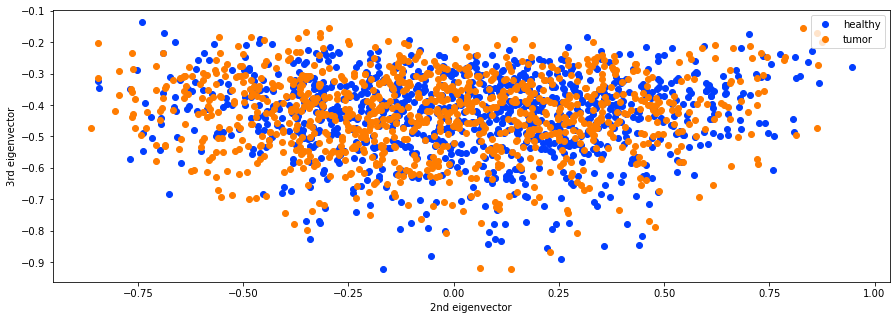

In [25]:
# Plot eigenvectors for the Varsim simulated dataset

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

base_dir = f'/Users/dd/work/svc/data/breakingpoint/'
data = np.loadtxt(f'{base_dir}/sim_mat_eigenvectors_norm.csv')
colors = sns.color_palette('bright')

x1 = data[:1000,1]
y1 = data[:1000,0]

x2 = data[1000:,1]
y2 = data[1000:,0]



print(data.shape)
fig, axs = plt.subplots(1, 1, figsize=(15,5))

axs.scatter(x1,y1, label='healthy', color = colors[0])
axs.scatter(x2,y2, label='tumor', color = colors[1])



axs.set(xlabel='2nd eigenvector', ylabel='3rd eigenvector')

#fig, axs = plt.subplots(1)
axs.legend(loc='upper right')

In [ ]:
# Write out the BAM files that make up each cluster

slice='B'

base_dir = f'/Users/dd/work/svc/data/silver_{slice}_5_05'
clusters = open(f'{base_dir}/clustering').readlines()[0][:-1].split(',')
clusters = [int(c) for c in clusters]

barcode_to_idx_lines = open(f'{base_dir}/../barcode_to_idx_{slice}.map').readlines()


cluster_count = int(max(clusters)) + 1

print(f'Found {cluster_count} clusters in clustering of size {len(clusters)}')
print(f'Found {len(barcode_to_idx_lines)} cells')

print('Creating a list of BAM files for each cluster...')


files = [i for i in range(0, cluster_count)]
files = [open(base_dir+'/cluster_' + str(i) + '.file_list', 'w') for i in range(0,cluster_count)]

for i in range(0, len(clusters)):
    fname = barcode_to_idx_lines[i].split('\t')[0] + '-1.bam'
    files[clusters[i]].write(fname + '\n')
    
for f in files:
    f.close()

print('Done!')
    
